In [206]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Import data
fi = pd.read_csv("final_inflation.csv")


In [207]:
import warnings
warnings.filterwarnings('ignore')


In [208]:
fi.head()

,Date,CPI,Change,Percent
0,2001-02-01,36.732042,1.077915,3.023256
1,2001-03-01,36.897875,0.912082,2.534562
2,2001-04-01,37.146625,0.829166,2.283105
3,2001-05-01,37.395374,0.912082,2.500000
4,2001-06-01,37.892874,1.243749,3.393665


In [209]:
fi.tail()

,Date,CPI,Change,Percent
239,2021-01-01,130.228035,3.992778,3.162966
240,2021-02-01,131.109443,5.639249,4.494493
241,2021-03-01,131.770499,7.065367,5.665658
242,2021-04-01,132.321379,6.468653,5.139860
243,2021-05-01,132.872259,6.637002,5.257646


In [210]:
fi.drop(['Change','Percent'],axis='columns',inplace=True)

In [212]:
fi.columns = ['Date','value']
fi.Date = pd.to_datetime(fi.Date)
fi.set_index(['Date'],inplace=True)

In [213]:
fi.shape

(244, 1)

In [214]:
fi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2001-02-01 to 2021-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   244 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


In [215]:
fi.isna().sum()

value    0
dtype: int64

In [216]:
fi.head()

,value
Date,
2001-02-01,36.732042
2001-03-01,36.897875
2001-04-01,37.146625
2001-05-01,37.395374
2001-06-01,37.892874


# general steps :-

    1. Visuallize the time series data to check weather data is stationary or not
    2. make time series stationary if not
    3. plot correlation or autocorrelation chart :- to check what will be the lag value
    4. construct the arima or seasonal arima model based on data
    5. use model to make prediction

#### 1. Visuallize the time series data to check weather data is stationary or not

<AxesSubplot:xlabel='Date'>

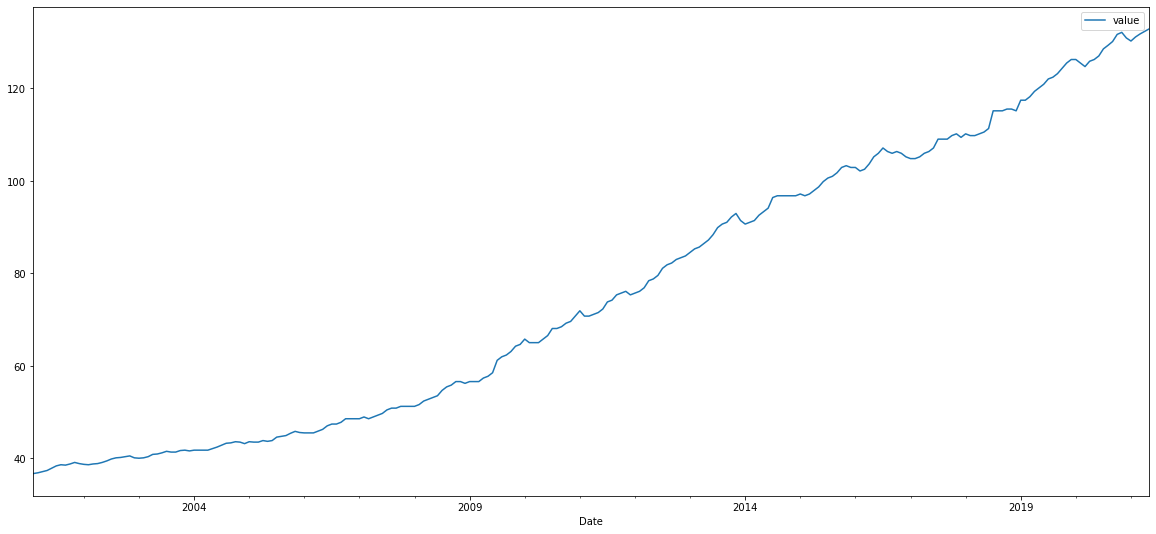

In [217]:
fi.plot(figsize = (20,9))

**checking the data is stationart or not**

this can be done by checking the null hypothesis

if **p value < 0.05** {[reject null hypothesis (H0)]  [accept alternate hypothesis (H1)]} --> data is **not stationary**

if **p value > 0.05** {[accept null hypothesis (H0)]  [reject alternate hypothesis (H1)]} --> data is **stationary**

In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

def adfuller_sationarity_test(dataset_column):
    result = adfuller(dataset_column)
    label = ['ADF statistics','p-value','lag used','number of observation used']

    for value,labels in zip(result,label):
        print(labels+' : '+str(value))

    if result[1] > 0.05:
        stationary  = 'data is not stationary'
        print(stationary)

    else:
        stationary = 'data is stationary'
        print(stationary)


In [218]:
adfuller_sationarity_test(fi)

ADF statistics : 0.5648439209748337
p-value : 0.9867162630770988
lag used : 15
number of observation used : 228
data is not stationary


#### 2. make time series stationary if not


#### differencing

In [219]:
fi['value'].shift(3)   #how much value you want to shift the value 

# it can be used for creating the data seasonal/quaterly we change the value by 12/4

Date
2001-02-01           NaN
2001-03-01           NaN
2001-04-01           NaN
2001-05-01     36.732042
2001-06-01     36.897875
                 ...    
2021-01-01    131.660323
2021-02-01    132.101027
2021-03-01    130.889091
2021-04-01    130.228035
2021-05-01    131.109443
Name: value, Length: 244, dtype: float64

In [220]:
fi1 = fi.copy()

**1**

In [221]:
fi1['monthly first differencing'] = fi1['value'] - fi1['value'].shift(1)

In [222]:
adfuller_sationarity_test(fi1['monthly first differencing'].dropna())

ADF statistics : -1.8589569409598716
p-value : 0.3516083916116959
lag used : 14
number of observation used : 228
data is not stationary


**2**

In [223]:
fi1['quaterly differencing'] = fi1['value'] - fi1['value'].shift(2)

In [224]:
adfuller_sationarity_test(fi1['quaterly differencing'].dropna())

ADF statistics : -1.7259633080060122
p-value : 0.4177874773083483
lag used : 14
number of observation used : 227
data is not stationary


<AxesSubplot:xlabel='Date'>

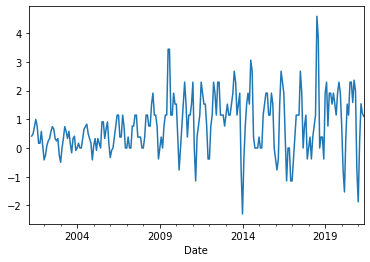

In [225]:
fi1['quaterly differencing'].plot()

**transformation**

<AxesSubplot:xlabel='Date'>

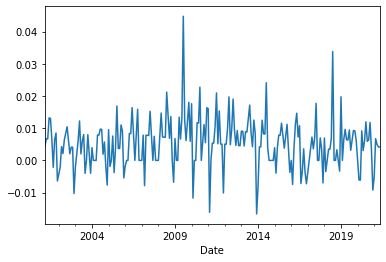

In [226]:
# log tranformation

fi1['value_log'] = np.log(fi1['value'])
fi1['value_log_diff'] = fi1['value_log'] - fi1['value_log'].shift(1)
fi1['value_log_diff'].dropna().plot()

In [227]:
adfuller_sationarity_test(fi1['value_log_diff'].dropna())

ADF statistics : -1.8408733424223276
p-value : 0.36036620584277623
lag used : 14
number of observation used : 228
data is not stationary


<AxesSubplot:xlabel='Date'>

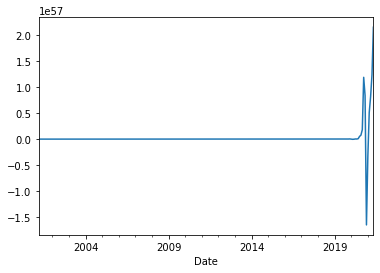

In [228]:
# exponetial transformation

fi1['value_exp'] = np.exp(fi1['value'])
fi1['value_exp_diff'] = fi1['value_exp'] - fi1['value_exp'].shift(1)
fi1['value_exp_diff'].dropna().plot()

# not be used

### plot correlation or autocorrelation chart :- to check what will be the lag value

In [25]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

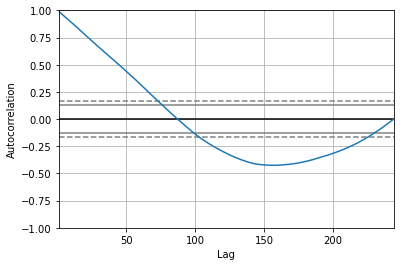

In [234]:
autocorrelation_plot(fi1['value'].dropna())

Identification of an **AR model** is often best done with the PACF.

    . For an AR model, the theoretical PACF "shuts off past the order of the model. The phrase "shuts off means that in theory the partal autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocomelations gives the order of the AR model. By the order of the model we mean the most extreme lag of x that is used as a predictor

Identification of an **MA model** is often best done with the ACF rather than the PACF

    For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocomelations only at lags involved in the model
    
**p,d,q** -->**p** AR model lags,**d** differencing,**q** MA lags 

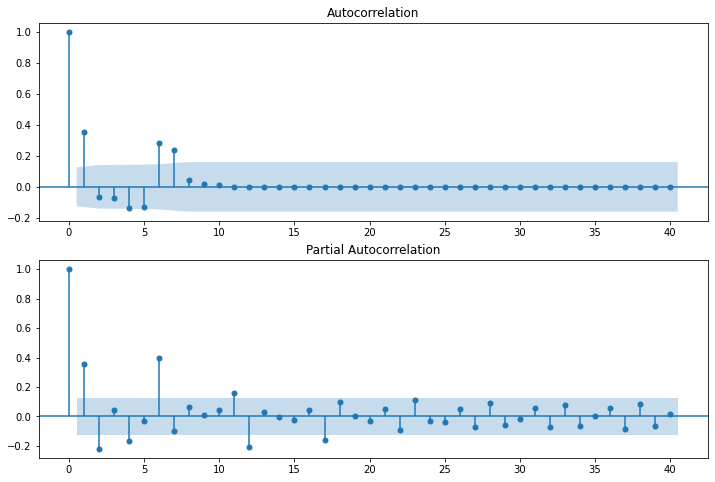

In [235]:
# finding the order of differencing

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fi1['value_exp_diff'].iloc[1:],lags=40,ax=ax1)

ax2 = fig.add_subplot(212)
fig  = sm.graphics.tsa.plot_pacf(fi1['value_exp_diff'].iloc[1:],lags=40, ax=ax2)


## construct the arima or seasonal arima model based on data

In [45]:
from statsmodels.tsa.arima_model import ARIMA
# from fbprophet import Prophet

**finding the best model**

In [103]:
def best_model(dataset_columns):
    
# split data into train and test
    train = dataset_columns.iloc[:int(len(dataset_columns)*0.85)]
    test = dataset_columns.iloc[int(len(dataset_columns)*0.85):]
    print(len(train),len(test))
    
# find the best model order for arima or sarima
    best_model_order = pm.auto_arima(train, 
                                     start_p=1, start_q=1, max_p=8, max_q=8, 
                                     start_P=0, start_Q=0, max_P=8, max_Q=8, m=12, 
                                     seasonal=True, trace=True, 
                                     d=1, D=1, 
                                     error_action='warn', 
                                     suppress_warnings=True, 
                                     random_state = 3, 
                                     n_fits=30)
    
    p = int(input('1st value or p :'))
    d = int(input('2nd value or d :'))
    q = int(input('3rd value or q :'))
    P = int(input('4th value or P :'))
    D = int(input('5th value or D :'))
    Q = int(input('6th value or Q :'))
    m =int(input('7th value or m :'))
    orders = [(p,d,q),(P,D,Q,m)]
    
########## -------- traning the model --------------- ##################

# Arima model  
    arima_model = ARIMA(train.dropna(), order=(p,d,q)).fit()
    
# sarima model
    sarima_model = sm.tsa.statespace.SARIMAX(train.dropna(),
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, m),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
    
# # prophet model
#     prophet_model = Prophet().fit(train.dropna())    
    
    
############ ----------- forcasting the value ------------ #################
# arima forcast
    arima_f,arima_se,arima_c = arima_model.forecast(len(test))
    
# sarima forcast
    sarima_f = sarima_model.forecast(len(test))

# #prophet forcast
#     prophet_f,prophet_se,prophet_c = prophet_model.forecast(len(test), alpha=0.05)


########### --------- accuracy ----------------- #############
# mean square error and root mean square error

    score_mse = [((arima_f - test.values) ** 2).mean(),
                 ((sarima_f - test.values) ** 2).mean()]
#                 ((prophet_f - test.values) ** 2).mean()]
    
    score_rmse = [format(round(np.sqrt(score_mse[0]), 2)),
                 format(round(np.sqrt(score_mse[1]), 2))]
#                  format(round(np.sqrt(score_mse[2]), 2))]
    
    return orders,best_model_order,score_mse,score_rmse,arima_model,sarima_model,train,test

In [104]:
order_,best_order_selector,s_mse,s_rmse,arima_model_,sarima_model_,train,test = best_model(fi1['value'])

207 37
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=321.159, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=326.670, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=267.382, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=242.083, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=319.251, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=244.080, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=244.081, Time=1.83 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=266.062, Time=0.33 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=245.607, Time=3.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=252.237, Time=0.32 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=243.765, Time=1.35 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=243.609, Time=0.54 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=242.041, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=320.732, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]  

In [105]:
order_

[(1, 1, 2), (0, 1, 1, 12)]

In [106]:
s_mse

[50.2684414544572, 42.39215223791656]

In [107]:
s_rmse

['7.09', '6.51']

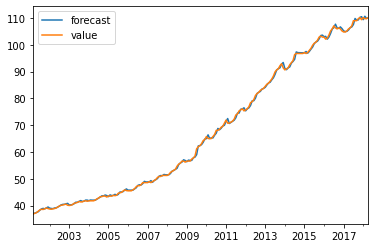

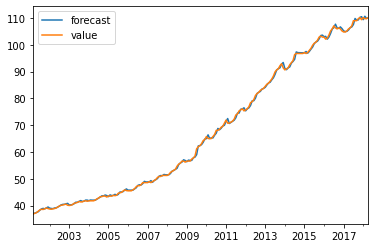

In [108]:
arima_model_.plot_predict()

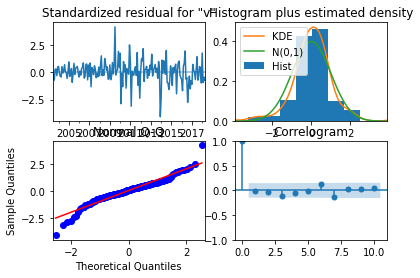

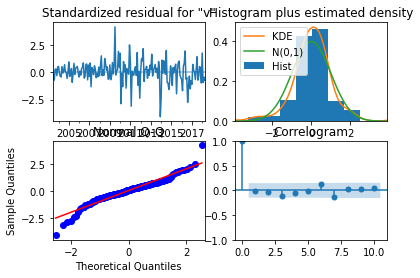

In [109]:
sarima_model_.plot_diagnostics()

### we are taking sarima for further analysis because it has better accuracy than arima

In [195]:
def model_visual_accuracy_testing(model,dataset,train):
    predict = sarima_model.predict(start = len(train),end=dataset.shape[0]-1,dynamic=True)
    result = dataset
    result_ = pd.concat([result,predict],axis='columns')
    print(result_.columns)
    actual = str(input('actual value column name : '))
    pred = str(input('predicted value column name : '))
    result_[[actual,pred]].plot(figsize = (20,9))
    

Index(['value', 'predicted_mean'], dtype='object')
actual value column name : value
predicted value column name : predicted_mean


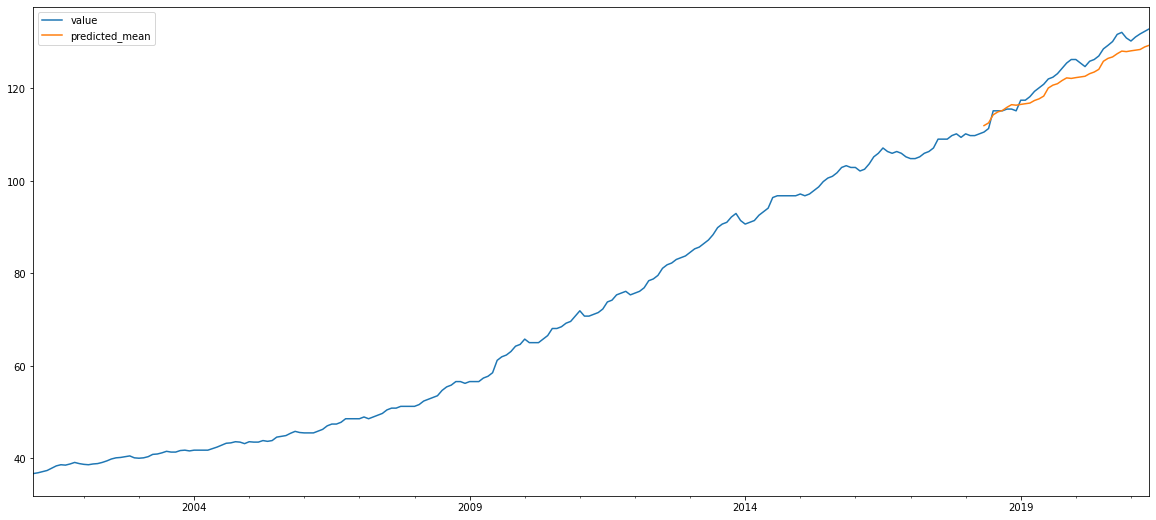

In [196]:
model_visual_accuracy_testing(sarima_model_,fi,train)

** **

#### 5. use model to make prediction

In [236]:
from pandas.tseries.offsets import DateOffset

In [201]:
def future_dated_dateset(dataset):

# forcasting for how much days/month/year
    count = int(input('how many days for daily dataset, month for monthly dataset, year for seasonal/yearly dataset (like, 23 months): '))

    future_dates = [dataset.index[-1]+ DateOffset(months = x)for x in range(0,count)]
    future_dates_df = pd.DataFrame(index=future_dates[1:],columns=dataset.columns)
    future_dataset = pd.concat([dataset,future_dates_df])
    
# checking which columns have values
    print(dataset.columns)
    col = str(input('name of the column which contain the actual values : '))

# model selection
    model_name = str(input('which model you are using for forcasting (arima,sarima): '))
    if model_name == 'arima':
        arima_final_model = ARIMA(dataset[col], order=(p,d,q)).fit()
        forcast = sarima_model_final.forecast(count, alpha=0.05)[0]
        
    elif model_name == 'sarima':
        sarima_model_final = sm.tsa.statespace.SARIMAX(dataset[col],
                                    order=order_[0],
                                    seasonal_order=order_[1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit()
        forcast = sarima_model_final.forecast(count, alpha=0.05)
    future_dataset = pd.concat([future_dataset,forcast])
    
    return future_dataset

In [202]:
future_inflation_dataset = future_dated_dateset(fi)

how many days for daily dataset, month for monthly dataset, year for seasonal/yearly dataset (like, 23 months): 24
Index(['value'], dtype='object')
name of the column which contain the actual values : value
which model you are using for forcasting (arima,sarima): sarima


In [203]:
future_inflation_dataset.head()

,value,0
2001-02-01,36.732042,NaN
2001-03-01,36.897875,NaN
2001-04-01,37.146625,NaN
2001-05-01,37.395374,NaN
2001-06-01,37.892874,NaN


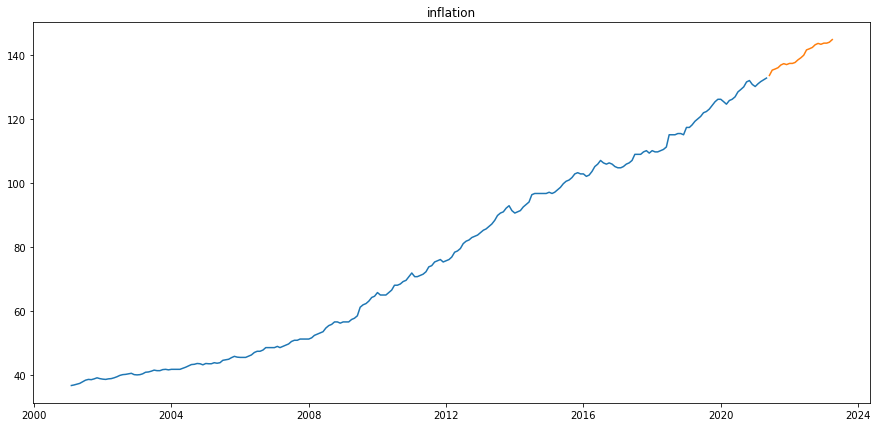

In [205]:
plt.figure(figsize = (15,7))
plt.plot(future_gdp['CIP'])
plt.plot(future_gdp['forcast'])
plt.title('inflation')
plt.show()